In [1]:
# Install extra dependencies
# !pip install -q torchinfo accelerate tqdm

import os
import json
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# pytorch dependency
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor

# HuggingFace accelerate library
from accelerate import Accelerator # (easy support for multiple GPU's, TPU, floating point 16s, which makes training much faster)

# displaying the pytorch architecture (makes prototyping the network easier, as it shows shapes)
from torchinfo import summary

# plotting the results
import matplotlib.pyplot as plt
import seaborn as sns 

# creatation and transformations for the dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image, ImageDraw

from collections import defaultdict

from IPython.display import clear_output

# show nice progress bar
from tqdm.notebook import tqdm

from time import time

import cv2

In [2]:
train_image_datapath = '/mnt/datasets/2DSS/2DSS/training/images'
train_mask_datapath = '/mnt/datasets/2DSS/2DSS/training/labels'
val_image_datapath = '/mnt/datasets/2DSS/2DSS/validation/images'
val_mask_datapath = '/mnt/datasets/2DSS/2DSS/validation/labels'
test_image_datapath = '/mnt/datasets/2DSS/2DSS/test/images'
test_mask_datapath = '/mnt/datasets/2DSS/2DSS/test/labels'

In [3]:
# list all, full datapaths for training and validation images and save them in these variables
training_images_paths = [os.path.join(train_image_datapath, f) for f in os.listdir(train_image_datapath)]
validation_images_paths = [os.path.join(val_image_datapath, f) for f in os.listdir(val_image_datapath)]
training_masks_paths = [os.path.join(train_mask_datapath, f) for f in os.listdir(train_mask_datapath)]
validation_masks_paths = [os.path.join(val_mask_datapath, f) for f in os.listdir(val_mask_datapath)]
test_images_paths = [os.path.join(test_image_datapath, f) for f in os.listdir(test_image_datapath)]
test_masks_paths = [os.path.join(test_mask_datapath, f) for f in os.listdir(test_mask_datapath)]
# sanity check, how many images & masks
print(f"size of training images : {len(training_images_paths)}")
print(f"size of validation images : {len(validation_images_paths)}")
print(f"size of training masks : {len(training_masks_paths)}")
print(f"size of validation masks : {len(validation_masks_paths)}")
print(f"size of test images : {len(test_images_paths)}")
print(f"size of test masks : {len(test_masks_paths)}")

size of training images : 12000
size of validation images : 1500
size of training masks : 12000
size of validation masks : 1500
size of test images : 1500
size of test masks : 1500


In [4]:
import os
import json
import numpy as np
import cv2

def create_mask_from_annotations(json_paths):
    """
    주어진 JSON 파일에서 폴리곤 좌표를 읽고, 클래스 우선순위에 따라 마스크를 생성하여 저장하는 함수

    Args:
        json_paths (list of str): JSON 파일 경로 리스트
    """
    try:
        # 디렉토리 내 모든 JSON 파일 순회
        mask_list = []
        for json_path in json_paths:
            if json_path.endswith('.json'):
                # JSON 파일 로드
                with open(json_path, 'r') as f:
                    data = json.load(f)

                image_name = data['image_name']
                image_size = data['image_size']
                annotations = data['Annotation']

                # 클래스 이름에 대한 고유한 클래스 ID 생성
                class_ids = {}
                current_id = 1  # 클래스 ID는 1부터 시작 (0은 배경)

                # 이미지 크기 설정
                image_width, image_height = image_size

                # 빈 마스크 생성                
                mask = np.zeros((image_height, image_width), dtype=np.uint8)

                # 폴리곤 그리기 (JSON 파일에 저장된 순서대로)
                for annotation in annotations:
                    class_name = annotation['class_name']
                    if class_name not in class_ids:
                        class_ids[class_name] = current_id
                        current_id += 1
                    class_id = class_ids[class_name]

                    for poly in annotation['data']:
                        polygon = np.array(poly, dtype=np.int32).reshape((-1, 2))
                        cv2.fillPoly(mask, [polygon], class_id)

                mask_list.append(mask)

    except Exception as e:
        print(f"An error occurred: {e}")

    return mask_list


In [5]:
train_masks = create_mask_from_annotations(training_masks_paths)

In [6]:
print(f"Generated {len(train_masks)} masks")

Generated 12000 masks


In [7]:
val_masks = create_mask_from_annotations(validation_masks_paths)

In [8]:
print(f"Generated {len(val_masks)} masks")

Generated 1500 masks


In [9]:
test_masks = create_mask_from_annotations(test_masks_paths)

In [10]:
print(f"Generated {len(test_masks)} masks")

Generated 1500 masks


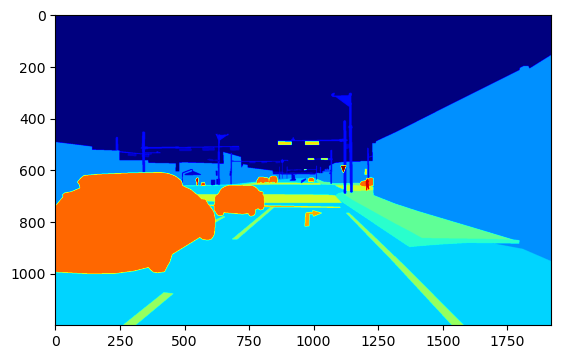

In [11]:
# 시각화
plt.imshow(train_masks[105], cmap='jet')
plt.show()